## Import required library

In [13]:
import nltk
nltk.download('punkt')
import pandas as pd
import spacy
import nltk
import string
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data preprocessing

In [1]:
import pandas as pd
top_df = pd.read_csv('Top_Artists.csv')
top_df.head()

,SongName,AlbumName,AlbumLink,Year,PlayCount,Lyrics,SongLink,Duration,artist
0,BIRDS OF A FEATHER,HIT ME HARD AND SOFT,https://open.spotify.com/album/7aJuG4TFXa2hmE4...,2024,3218891371,('Til I'm in the grave)\r\nI want you to stay\...,https://open.spotify.com/track/6dOtVTDdiauQNBQ...,210,Billie_Ilish
1,you should see me in a crown,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",https://open.spotify.com/album/0S0KGZnfBGSIssf...,2019,1000101010,"Bite my tongue, bide my time\r\nWearing a warn...",https://open.spotify.com/track/3XF5xLJHOQQRbWy...,180,Billie_Ilish
2,GOLDWING,Happier Than Ever,https://open.spotify.com/album/0JGOiO34nwfUdDr...,2021,162632187,He hath come to the bosom of his beloved\r\nSm...,https://open.spotify.com/track/0FfqyjhB6Kspvit...,151,Billie_Ilish
3,Getting Older,Happier Than Ever,https://open.spotify.com/album/0JGOiO34nwfUdDr...,2021,334347982,"I'm getting older, I think I'm aging well\r\nI...",https://open.spotify.com/track/4HOryCnbme0zBnF...,244,Billie_Ilish
4,Your Power,Happier Than Ever,https://open.spotify.com/album/0JGOiO34nwfUdDr...,2021,526977340,Try not to abuse your power\r\nI know we didn'...,https://open.spotify.com/track/042Sl6Mn83JHyLE...,245,Billie_Ilish


In [7]:
# Load the English model from spaCy
nlp = spacy.load("en_core_web_sm")

# Create a set of English stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and token.text not in stop_words
    ]
    return " ".join(tokens)

In [ ]:
Top_lyrics = top_df.copy()

In [21]:
Top_lyrics['Lyrics'] = top_df['Lyrics'].apply(preprocess_text)
Top_lyrics.head() 

,Lyrics,weird_chars,clean_lyrics
0,til grave want stay til grave til rot away dea...,[],til grave want stay til grave til rot away dea...
1,bite tongue bide time wear warning sign wait t...,[],bite tongue bide time wear warning sign wait t...
2,hath come bosom beloved smile beareth high yea...,[],hath come bosom beloved smile beareth high yea...
3,get old think age well wish someone tell reaso...,[],get old think age well wish someone tell reaso...
4,try abuse power know choose change might wanna...,[],try abuse power know choose change might wanna...


In [22]:
Top_lyrics = pd.DataFrame(Top_lyrics['Lyrics'])
Top_lyrics.head()

,Lyrics
0,til grave want stay til grave til rot away dea...
1,bite tongue bide time wear warning sign wait t...
2,hath come bosom beloved smile beareth high yea...
3,get old think age well wish someone tell reaso...
4,try abuse power know choose change might wanna...


In [89]:
lyric_fillers = [
    "oh", "ooh", "ooo", "ah", "aah", "mm", "mmm", "mmh",
    "eh", "hey", "ha", "la", "da", "nah", "yeah", "yea","bitch", "shit", "fuck", "nigga", "na", "niggas", "whoa",
    "woah", "ya" , "hol", "whoo", "gon",
    "pop" , "know" , "say" , "man",
    "di", "huh", "uh" , "woo" ,"yah"
]

In [90]:
def clean_text_lda(text):
    text = text.lower()
    text = re.sub(r"[^\x00-\x7F]", " ", text)  # Remove ASCII outside
    text = re.sub(r"[^a-z\s]", " ", text)     # a–z
    text = re.sub(r"\s+", " ", text)          # Multiple spaces to single space
    pattern = r"\b(" + "|".join(lyric_fillers) + r")\b" # remove fillers
    text = re.sub(pattern, " ", text)
    return text.strip()

Top_lyrics["clean_lyrics"] = Top_lyrics["Lyrics"].apply(clean_text_lda)

### Double check

In [91]:
from collections import Counter

all_weird = []
for t in Top_lyrics["clean_lyrics"]:
    all_weird.extend(re.findall(r"[^a-zA-Z0-9\s]", t))

Counter(all_weird).most_common(20)

[]

### LDA

In [92]:
Top_lyrics.head()

,Lyrics,clean_lyrics,Top_LDA_Topic,LDA_Topic_Keywords
0,til grave want stay til grave til rot away dea...,til grave want stay til grave til rot away dea...,3,"love, like, baby, time, feel, make, come, tell..."
1,bite tongue bide time wear warning sign wait t...,bite tongue bide time wear warning sign wait t...,3,"love, like, baby, time, feel, make, come, tell..."
2,hath come bosom beloved smile beareth high yea...,hath come bosom beloved smile beareth high yea...,1,"like, make, need, look, come, want, money, god..."
3,get old think age well wish someone tell reaso...,get old think age well wish someone tell reaso...,3,"love, like, baby, time, feel, make, come, tell..."
4,try abuse power know choose change might wanna...,try abuse power choose change might wanna lo...,3,"love, like, baby, time, feel, make, come, tell..."


In [93]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Text to vector
vectorizer = CountVectorizer(stop_words="english")
doc_term_matrix = vectorizer.fit_transform(Top_lyrics["clean_lyrics"])
feature_names = vectorizer.get_feature_names_out()

#### Decide the number of topics

In [94]:
# LDA Model and Perplexity Calculation
for n_topics in range(2, 15):
    model = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    model.fit(doc_term_matrix)
    perplexity = model.perplexity(doc_term_matrix)
    print(f"Topics: {n_topics} → Perplexity: {perplexity:.2f}")

Topics: 2 → Perplexity: 1903.09
Topics: 3 → Perplexity: 1867.14
Topics: 4 → Perplexity: 1864.38
Topics: 5 → Perplexity: 1896.60
Topics: 6 → Perplexity: 1907.01
Topics: 7 → Perplexity: 1909.30
Topics: 8 → Perplexity: 1881.95
Topics: 9 → Perplexity: 1889.80
Topics: 10 → Perplexity: 1884.62
Topics: 11 → Perplexity: 1881.84
Topics: 12 → Perplexity: 1879.13
Topics: 13 → Perplexity: 1884.31
Topics: 14 → Perplexity: 1889.27


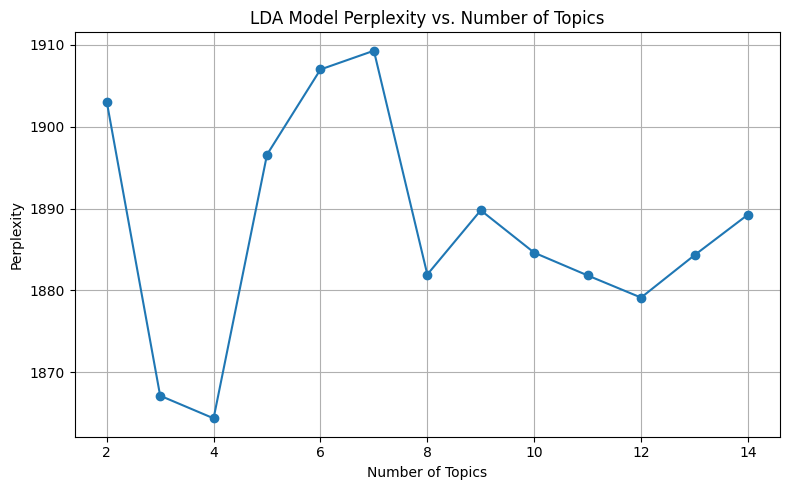

In [95]:
import matplotlib.pyplot as plt

perplexities = []
topic_range = range(2, 15)

for n_topics in topic_range:
    model = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    model.fit(doc_term_matrix)
    perplexity = model.perplexity(doc_term_matrix)
    perplexities.append(perplexity)

plt.figure(figsize=(8, 5))
plt.plot(topic_range, perplexities, marker='o')
plt.title("LDA Model Perplexity vs. Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.grid(True)
plt.tight_layout()
plt.show()

Elbow + minium region ==> N=4

In [ ]:
n_topics = 4  # Can be adjusted based on analysis
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(doc_term_matrix)

# Get the top keywords (top 14) for each topic
topic_words = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_features = [feature_names[i] for i in topic.argsort()[:-15:-1]]
    topic_words.append(", ".join(top_features))

# Assign the most probable topic and its representative keywords to each question
doc_topic_distrib = lda_model.transform(doc_term_matrix)  # ✅ Using doc_term_matrix here as well
Top_lyrics["Top_LDA_Topic"] = doc_topic_distrib.argmax(axis=1)
Top_lyrics["LDA_Topic_Keywords"] = Top_lyrics["Top_LDA_Topic"].apply(lambda x: topic_words[x])

Top_lyrics.head()

,Lyrics,clean_lyrics,Top_LDA_Topic,LDA_Topic_Keywords
0,til grave want stay til grave til rot away dea...,til grave want stay til grave til rot away dea...,0,"like, baby, let, time, make, feel, love, tell,..."
1,bite tongue bide time wear warning sign wait t...,bite tongue bide time wear warning sign wait t...,0,"like, baby, let, time, make, feel, love, tell,..."
2,hath come bosom beloved smile beareth high yea...,hath come bosom beloved smile beareth high yea...,3,"love, come, like, girl, baby, long, need, look..."
3,get old think age well wish someone tell reaso...,get old think age well wish someone tell reaso...,0,"like, baby, let, time, make, feel, love, tell,..."
4,try abuse power know choose change might wanna...,try abuse power choose change might wanna lo...,0,"like, baby, let, time, make, feel, love, tell,..."


In [97]:
Top_lyrics["LDA_Topic_Keywords"].value_counts()

LDA_Topic_Keywords
like, baby, let, time, make, feel, love, tell, wanna, want, need, right, way, come      628
like, come, high, want, make, night, life, money, need, real, really, let, tell, big    193
like, make, time, come, tell, think, let, need, wanna, girl, way, money, black, new     189
love, come, like, girl, baby, long, need, look, want, feel, new, make, time, way        140
Name: count, dtype: int64

In [133]:
Top_lyrics.to_csv("LDA_Top_Artists_Topics.csv", index=False)

In [134]:
# 先把 value_counts 轉成 DataFrame
topic_counts = Top_lyrics["LDA_Topic_Keywords"].value_counts().reset_index()

# 改欄位名稱
topic_counts.columns = ["LDA_Topic_Keywords", "Count"]

# 加一個主題編號欄位（Topic1, Topic2, ...）
topic_counts["Topic_ID"] = [f"Topic{i+1}" for i in range(len(topic_counts))]

# 調整欄位順序：主題編號、關鍵字、數量
topic_table = topic_counts[["Topic_ID", "LDA_Topic_Keywords", "Count"]]

topic_table.head()   # 看前幾列

,Topic_ID,LDA_Topic_Keywords,Count
0,Topic1,"like, baby, let, time, make, feel, love, tell, wanna, want, need, right, way, come",628
1,Topic2,"like, come, high, want, make, night, life, money, need, real, really, let, tell, big",193
2,Topic3,"like, make, time, come, tell, think, let, need, wanna, girl, way, money, black, new",189
3,Topic4,"love, come, like, girl, baby, long, need, look, want, feel, new, make, time, way",140


In [136]:
topic_table.to_csv("LDA_Top_Topic_Summary.csv", index=False)

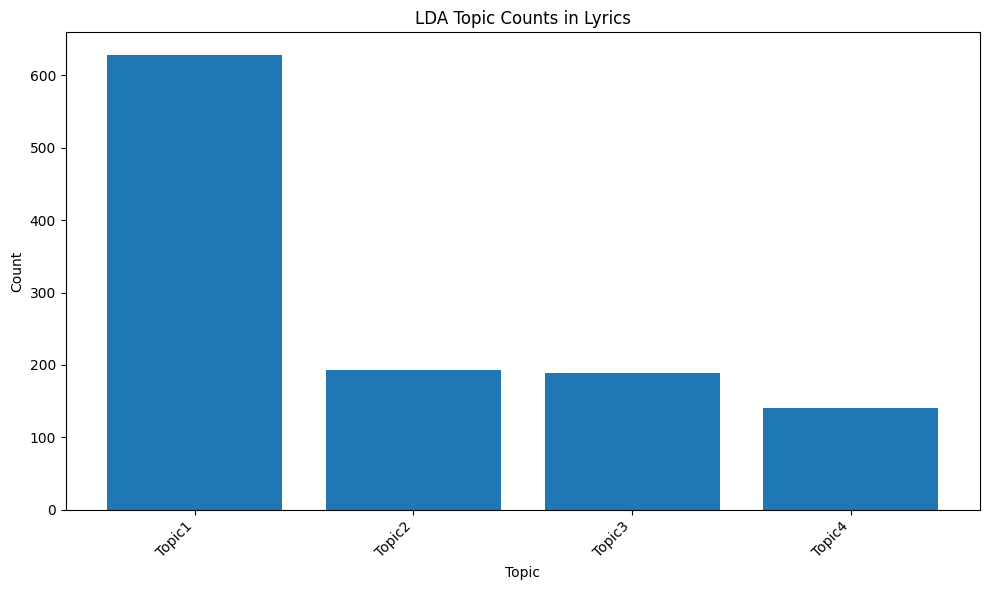

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(topic_table["Topic_ID"], topic_table["Count"])

plt.xlabel("Topic")
plt.ylabel("Count")
plt.title("LDA Topic Counts in Lyrics")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Transformer to generate topic

In [100]:
import torch
import torch.nn.functional as F
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    GPT2LMHeadModel, GPT2Tokenizer,
    pipeline
)

In [101]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [157]:

# YOUR CODE HERE:
# 1. Load GPT-2 model and tokenizer
print("Loading GPT-2 tokenizer...")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to(device)
model.eval()  # Set to evaluation mode

# 2. Create function to generate product descriptions
#    def generate_description(prompt, **generation_params):
#        # Your implementation
#        pass
def generate_text(prompt,
                  max_length=150,
                  temperature=1.0,
                  top_k=50,
                  top_p=0.95,
                  num_return_sequences=1):
    """
    Generate text using GPT-2.

    Args:
        prompt: Starting text
        max_length: Maximum length of generated text
        temperature: Randomness (higher = more random)
        top_k: Consider top k words
        top_p: Nucleus sampling threshold
        num_return_sequences: Number of generations to return

    Returns:
        List of generated texts
    """
    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Generate
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=max_length,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            num_return_sequences=num_return_sequences,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode and return
    generated_texts = []
    for i in range(num_return_sequences):
        text = tokenizer.decode(output[i], skip_special_tokens=True)
        generated_texts.append(text)

    return generated_texts

print("✓ Generation function ready!")

# 3. Generate descriptions for 3 product categories
#    Try different parameters:
#    - temperature (0.7, 1.0)
#    - top_k (50, 100)
#    - top_p (0.9, 0.95)
#    - max_length (50, 100)

product_prompts = {
    "Topic1": "Please guess a topic of song based on these words: like, baby, let, time, make, feel, love, tell, wanna, want, need, right, way, come.",
    "Topic2": "Please guess a topic of song based on these words:like, come, high, want, make, night, life, money, need, real, really, let, tell, big.",
    "Topic3": "Please guess a topic of song based on these words:like, make, time, come, tell, think, let, need, wanna, girl, way, money, black, new.",
    "Topic4": "Please guess a topic of song based on these words:love, come, like, girl, baby, long, need, look, want, feel, new, make, time, way."

}

# Different generation configurations
generation_configs = [
    {"name": "temp_0.7_topk_50", "temperature": 0.7, "top_k": 50, "top_p": 0.9,  "max_length": 150},
    {"name": "temp_1.0_topk_50", "temperature": 1.0, "top_k": 50, "top_p": 0.95, "max_length": 150},
    {"name": "temp_0.7_topk_100","temperature": 0.7, "top_k": 100,"top_p": 0.9,  "max_length": 150},
    {"name": "temp_1.0_topk_100","temperature": 1.0, "top_k": 100,"top_p": 0.95, "max_length": 150},
]

generated_results = []

for category, prompt in product_prompts.items():
    print(f"\n=== Category: {category} ===")
    print(f"Prompt: {prompt}\n")

    for cfg in generation_configs:
        text = generate_text(
            prompt,
            max_length=cfg["max_length"],
            temperature=cfg["temperature"],
            top_k=cfg["top_k"],
            top_p=cfg["top_p"],
            num_return_sequences=1
        )[0]

        print(f"[{cfg['name']}]")
        print(text)
        print("-" * 60)

        generated_results.append({
            "category": category,
            "config": cfg["name"],
            "text": text
        })

# 4. Implement quality checks:
#    - Length check
#    - Inappropriate content filter
#    - Relevance check
bad_words = []
def quality_check(text, category, min_words=20):
    """
    Return a dictionary containing:
    -length_ok: whether the text is long enough
    -has_bad_content: whether the text includes inappropriate words
    -relevant: whether the text is related to the category (checked using simple keywords)
    """
    lower = text.lower()
    words = lower.split()

    # lenth check
    length_ok = len(words) >= min_words

    # unappropriate content check
    has_bad = any(bad in lower for bad in bad_words)

    # relevance check
    keywords_map = {
        
    }
    keywords = keywords_map.get(category, [])
    relevant = any(kw in lower for kw in keywords)

    return {
        "length_ok": length_ok,
        "has_bad_content": has_bad,
        "relevant": relevant
    }

print("\n=== Quality checks ===")
for item in generated_results:
    qc = quality_check(item["text"], item["category"])
    print(f"\nCategory: {item['category']} | Config: {item['config']}")
    print(f"Length OK:         {qc['length_ok']}")
    print(f"Inappropriate?:    {qc['has_bad_content']}")
    print(f"Relevant to topic: {qc['relevant']}")

Loading GPT-2 tokenizer...
✓ Generation function ready!

=== Category: Topic1 ===
Prompt: Please guess a topic of song based on these words: like, baby, let, time, make, feel, love, tell, wanna, want, need, right, way, come.

[temp_0.7_topk_50]
Please guess a topic of song based on these words: like, baby, let, time, make, feel, love, tell, wanna, want, need, right, way, come.

Now, that's a lot of words to write about. But I think that it's important to remember that there are so many different kinds of words, and so many different kinds of things that can be said about a topic of songs, and so many different kinds of words that can be said about a topic of songs. So I think that the best way to think about these words is to think about the way songs are thought about in terms of things that are written about them. And I think that what I've done is really done in
------------------------------------------------------------
[temp_1.0_topk_50]
Please guess a topic of song based on thes

In [158]:
top_topics = pd.DataFrame(generated_results)
pd.set_option('display.max_colwidth', None)  # 不限制文字長度 
top_topics

,category,config,text
0,Topic1,temp_0.7_topk_50,"Please guess a topic of song based on these words: like, baby, let, time, make, feel, love, tell, wanna, want, need, right, way, come.\n\nNow, that's a lot of words to write about. But I think that it's important to remember that there are so many different kinds of words, and so many different kinds of things that can be said about a topic of songs, and so many different kinds of words that can be said about a topic of songs. So I think that the best way to think about these words is to think about the way songs are thought about in terms of things that are written about them. And I think that what I've done is really done in"
1,Topic1,temp_1.0_topk_50,"Please guess a topic of song based on these words: like, baby, let, time, make, feel, love, tell, wanna, want, need, right, way, come. But if the sentence is: ""it does love you, you love you in love,"" well, that'd be too much. ""The truth"" (a phrase coined by Mary Ellen White) is that there is an active, non-verbal and a negative, but active and positive relationship. In many ways this could be called ""the romantic kiss,"" but it makes no sense to me because this phrase is almost always used to explain how good a partner or girlfriend is in life (unless you are a professional or are an ""academic""), in a"
2,Topic1,temp_0.7_topk_100,"Please guess a topic of song based on these words: like, baby, let, time, make, feel, love, tell, wanna, want, need, right, way, come.\n\nYou may have heard of the word ""soul"" in the past, but it's been around for a long time. A lot of people don't even know that ""soul"" is a synonym for ""love"", or at least, it's not a synonym for ""love"" in the sense of being happy. There are many different ways to describe this word, but what we have here is a very simple, and often misunderstood, way to express the meaning of these words.\n\nFor example, if you're saying"
3,Topic1,temp_1.0_topk_100,"Please guess a topic of song based on these words: like, baby, let, time, make, feel, love, tell, wanna, want, need, right, way, come. And while it's a lot, I guess it's also a good place to start.\n\nI love writing songs about our world because if we really love it, we can make something awesome happen. If the world is perfect, nothing will ever catch fire. There'll be rain in the morning when it rains, people will be screaming at each other, people will get drunk all the time, music will change, new cultures will come, and anything we find lives to celebrate.\n\nBut there can be some good magic on the horizon that no"
4,Topic2,temp_0.7_topk_50,"Please guess a topic of song based on these words:like, come, high, want, make, night, life, money, need, real, really, let, tell, big.\n\n""How can you make money when you can't make money on a song like this?""\n\n""A song like this is so bad, it's not even worth my time to make it.""\n\n""Well, I'm going to make it, I'm going to make it, I'm going to make it, I'm going to make it, I'm going to make it.""\n\n""But you know what, that's not really a good song, it's not even good.""\n\n""Yeah, I think"
5,Topic2,temp_1.0_topk_50,"Please guess a topic of song based on these words:like, come, high, want, make, night, life, money, need, real, really, let, tell, big. So we should make that the perfect song. (In this song, you may also have to ""make it big"" or ""make it big"" as well.) Then the song has to be very interesting, or you get the idea of this song as a joke. The song needs to have a really clear, powerful purpose, or the ""wow factor"" has to be very prominent and the song is too catchy to hold the listener up. So let's give it a try. Here's the song I use to start this process.1:4"
6,Topic2,temp_0.7_topk_100,"Please guess a topic of song based on these words:like, come, high, want, make, night, life, money, need, real, really, let, tell, big. I don't want to be like that, but I want to be really, really, really big. I want to be like that, but I want to be 

In [159]:
top_topics["final_topic"] = (
    top_topics["text"]
        .str.replace(r"^Please guess a topic.*?\.", "", regex=True)
        .str.strip()
)

In [160]:
top_topics["final_topic"]

0     Now, that's a lot of words to write about. But I think that it's important to remember that there are so many different kinds of words, and so many different kinds of things that can be said about a topic of songs, and so many different kinds of words that can be said about a topic of songs. So I think that the best way to think about these words is to think about the way songs are thought about in terms of things that are written about them. And I think that what I've done is really done in
1                            But if the sentence is: "it does love you, you love you in love," well, that'd be too much. "The truth" (a phrase coined by Mary Ellen White) is that there is an active, non-verbal and a negative, but active and positive relationship. In many ways this could be called "the romantic kiss," but it makes no sense to me because this phrase is almost always used to explain how good a partner or girlfriend is in life (unless you are a professional or are an "academic"),

In [161]:
top_topics[['category', 'final_topic']]

,category,final_topic
0,Topic1,"Now, that's a lot of words to write about. But I think that it's important to remember that there are so many different kinds of words, and so many different kinds of things that can be said about a topic of songs, and so many different kinds of words that can be said about a topic of songs. So I think that the best way to think about these words is to think about the way songs are thought about in terms of things that are written about them. And I think that what I've done is really done in"
1,Topic1,"But if the sentence is: ""it does love you, you love you in love,"" well, that'd be too much. ""The truth"" (a phrase coined by Mary Ellen White) is that there is an active, non-verbal and a negative, but active and positive relationship. In many ways this could be called ""the romantic kiss,"" but it makes no sense to me because this phrase is almost always used to explain how good a partner or girlfriend is in life (unless you are a professional or are an ""academic""), in a"
2,Topic1,"You may have heard of the word ""soul"" in the past, but it's been around for a long time. A lot of people don't even know that ""soul"" is a synonym for ""love"", or at least, it's not a synonym for ""love"" in the sense of being happy. There are many different ways to describe this word, but what we have here is a very simple, and often misunderstood, way to express the meaning of these words.\n\nFor example, if you're saying"
3,Topic1,"And while it's a lot, I guess it's also a good place to start.\n\nI love writing songs about our world because if we really love it, we can make something awesome happen. If the world is perfect, nothing will ever catch fire. There'll be rain in the morning when it rains, people will be screaming at each other, people will get drunk all the time, music will change, new cultures will come, and anything we find lives to celebrate.\n\nBut there can be some good magic on the horizon that no"
4,Topic2,"""How can you make money when you can't make money on a song like this?""\n\n""A song like this is so bad, it's not even worth my time to make it.""\n\n""Well, I'm going to make it, I'm going to make it, I'm going to make it, I'm going to make it, I'm going to make it.""\n\n""But you know what, that's not really a good song, it's not even good.""\n\n""Yeah, I think"
5,Topic2,"So we should make that the perfect song. (In this song, you may also have to ""make it big"" or ""make it big"" as well.) Then the song has to be very interesting, or you get the idea of this song as a joke. The song needs to have a really clear, powerful purpose, or the ""wow factor"" has to be very prominent and the song is too catchy to hold the listener up. So let's give it a try. Here's the song I use to start this process.1:4"
6,Topic2,"I don't want to be like that, but I want to be really, really, really big. I want to be like that, but I want to be really, really, really big. I want to be like that, but I want to be really, really, really big. I want to be like that, but I want to be really, really, really big. I want to be like that, but I want to be really, really, really big. I want to be like that, but I want to be really,"
7,Topic2,"And we'll play a bunch of songs for you in less than an hour.\n\nWhat happens next?\n\nThere are tons of ideas for a new project. Here are the possibilities and things that we will write down now. First we need to get everything ready. So we can't just use ""we'll make "" our music or ""they'll make "" our music"" or any other word. We'll need to figure out what we'll do if we're going to write something, and what we'll do if we don't"
8,Topic3,"And if you don't know, they are the words of a person. And if you don't know, they are the words of a person.\n\n\nI am sorry if the person said something that I didn't mean. I am sorry if the person said something that I didn't mean.\n\n\nI am sorry if the person said something that I didn't mean.\n\n\nI am sorry if the person said